# Exercises 5: STC/GLM ##

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate
from scipy import optimize

## 1. STC ##

(a) Create the filters from 0ms to 20ms with a bin size of 1ms. Also, normalize the filter amplitudes
by numpy.linalg.norm.

In [2]:
def filter_a(t):
    result = np.exp((-(t - 10) ** 2) / 10) * np.cos(2 * np.pi * (t - 10) / 10)
    return result

def filter_b(t):
    result = np.exp((-(t - 10) ** 2) / 10) * np.cos((2 * np.pi * (t - 10) / 10) + (np.pi / 2))
    return result

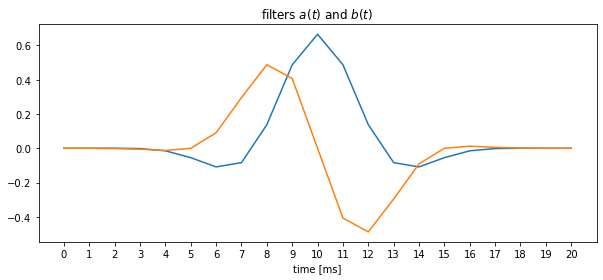

In [3]:
ts = 1
t_f = np.arange(0, 20+1, ts)

a = filter_a(t_f) / np.linalg.norm(filter_a(t_f))
b = filter_b(t_f) / np.linalg.norm(filter_b(t_f))

plt.figure(figsize=(10,4))
plt.plot(t_f, a)
plt.plot(t_f, b)
plt.xlabel('time [ms]')
plt.xticks(list(range(21)))
_ = plt.title('filters $a(t)$ and $b(t)$')

b) Generate a white noise stimulus x(t) for 100s with a bin size of 1ms.

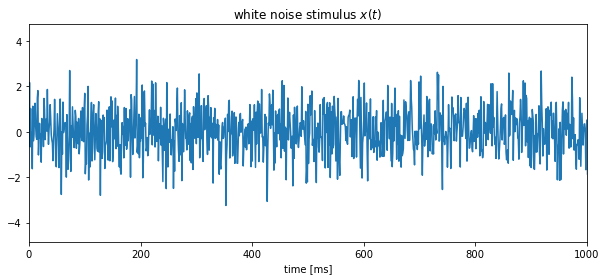

In [4]:
t_x = np.arange(0, 100000, 1)
x = np.random.normal(size = 100000)

plt.figure(figsize=(10,4))
plt.plot(t_x, x)
plt.xlabel('time [ms]')
plt.xlim(0,1000)
_ = plt.title('white noise stimulus $x(t)$')

(c) Consider a neural system which takes x(t) as input and produce an output r(t) with a squaring nonlinearity by

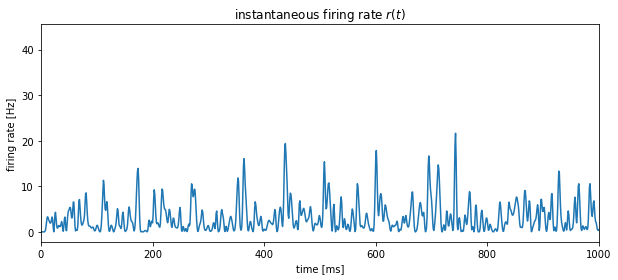

In [5]:
n_filter = len(a)
x_padded = np.hstack((np.zeros(n_filter-1), x))

r = 2 * (np.convolve(x_padded, a, mode='valid') ** 2) + 1.5 * (np.convolve(x_padded, b, mode='valid') ** 2)

plt.figure(figsize=(10,4))
plt.plot(t_x, r)
plt.xlabel('time [ms]')
plt.ylabel('firing rate [Hz]')
plt.xlim(0,1000)
_ = plt.title('instantaneous firing rate $r(t)$')

(d) The output r(t) is firing rate. Consider an inhomogeneous poisson process with instantaneous firing rate of r(t). Sample a spike train from this process until 100s.

In [6]:
def inhomogeneous_poission(N, T, r, ts = 1):
    t_all_trials = []

    for i_trial in range(N):
        left_expression = np.nan
        m = i_trial + 1
        t_trial = [0]

        t = 0
        right_expression = 0
        
        while t_trial[-1] < T:
            u = np.random.rand()

            if np.isnan(left_expression):
                left_expression = -np.log(1-u)
            else:
                left_expression += -np.log(1-u)

            while left_expression > right_expression:
                right_expression = np.trapz(r[:t])
                
                if left_expression > right_expression:
                    t += ts
                    if t >= T:
                        break

            if t >= T:
                break
            else:
                t_trial.append(t)
        t_trial.pop(0)
        t_all_trials.append(t_trial)
    return t_all_trials

# call function
N = 1
T = 100000
s = inhomogeneous_poission(1, T, r, ts)

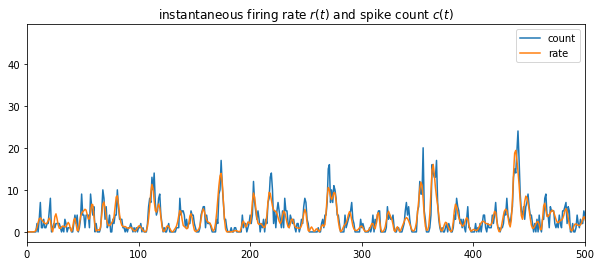

In [7]:
count = np.zeros((T))

for i in s[0]:
    count[i-1] = count[i-1] + 1
    
plt.figure(figsize=(10,4))
plt.plot(t_x, count, label='count')
plt.plot(t_x, r, label='rate')
plt.xlim(0, 500)
plt.legend()
_ = plt.title('instantaneous firing rate $r(t)$ and spike count $c(t)$')

(e) Compute the spike-triggered average (STA) up to $N_{filter}$ time bins before the spikes.

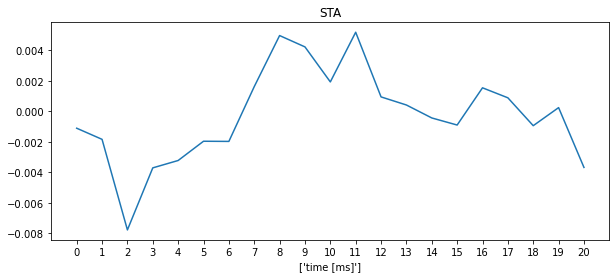

In [8]:
window = n_filter

all_spikes_idx = np.where(count > 0)
spikes_idx = all_spikes_idx[0][all_spikes_idx[0]>n_filter]
spikes_counts = count[spikes_idx]

snippets_idx = np.zeros((len(spikes_idx), window)).astype('int')
for i in range(len(spikes_idx)):
    snippets_idx[i, :] = list(range((spikes_idx[i]-window),(spikes_idx[i])))


stimuli_snippets = np.zeros((len(spikes_idx), window))
for i in range(len(spikes_idx)):
    stimuli_snippets[i, :] = x[snippets_idx[i, :]]

sta = np.average(stimuli_snippets, axis = 0, weights = spikes_counts.flatten())

t_window = np.arange(0, n_filter, ts)

plt.figure(figsize=(10,4))
plt.plot(t_window, sta)
plt.xlabel(['time [ms]'])
plt.xticks(list(range(21)))
_ = plt.title('STA')

(f) Compute the spike-triggered covariance (STC).

In [9]:
xi = stimuli_snippets - sta

stc = np.cov(xi.T, ddof = 0, fweights = spikes_counts.flatten())

(g) Obtain the eigenvectors and eigenvalues of the STC. (You could use the function numpy.linalg.eig.)
Plot the eigenvalues from high to low. You should see two eigenvalues which are particularly higher
than the rest.

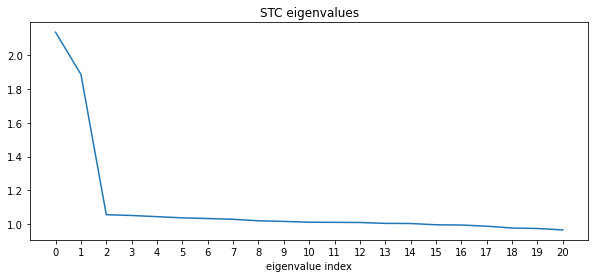

In [10]:
w, v = np.linalg.eig(stc)

sort_eig = np.argsort(w)[::-1]
w_sorted = w[sort_eig]
v_sorted = v[:, sort_eig]

plt.figure(figsize=(10,4))
plt.plot(w_sorted)
plt.xlabel('eigenvalue index')
plt.xticks(list(range(len(a))))
_ = plt.title('STC eigenvalues')

(h) Plot the corresponding eigenvectors of these two eigenvalues. They should look similar to the
filters a(t) and b(t). The signs can be opposite (the eigenvectors have negative values instead of
positive). Why?

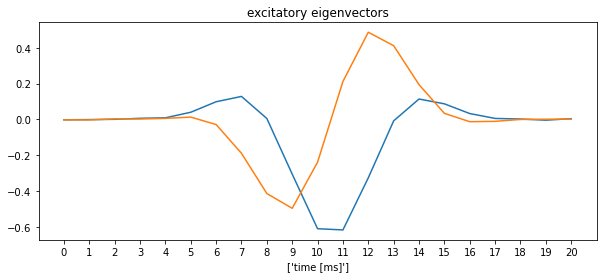

In [11]:
plt.figure(figsize=(10,4))
plt.plot(t_f, v_sorted[:, 0])
plt.plot(t_f, v_sorted[:, 1])
plt.xlabel(['time [ms]'])
plt.xticks(list(range(21)))
_ = plt.title('excitatory eigenvectors')

Negative values instead of positive: Eigenvector just means that all vectors that fall on this vector are just scaled by the corresponding eigenvalue as a result of the matrix transformation. Eigenvectors $(-1,-1)$ and $(1,1)$ therefore are equivalent.

(i) How would the model generalize to two pixels (a whitenoise vector $\vec{x}$ with two entries)? How
many kernels could there be for n pixels?

One pixel: $(1 \cdot t) ^ 2 = 21 ^ 2$

Two pixels: $(2 \cdot t) ^ 2 = (2 \cdot 21) ^ 2 = 42^2$

n pixels: $(n \cdot t) ^ 2 = (n \cdot 21)^2$

## 2. GLM-based spike fitting ##

(d) (Python exercise) Let us consider the two specific kernels

$$\phi_t = a t ~ exp[−(t b)^2/2] $$
$$\eta_t = d/c ~ exp[−tc]~H(t) $$

with $H$ denoting the Heaviside function. Plot the kernels and give biological motivations.

In [12]:
# define filters
def phi(t, a, b):
    result = a * t * np.exp(-((t * b) ** 2) / 2)
    return result

def eta(t, d, c):
    result = np.zeros(len(t))
    for i in range(len(t)):
        result[i] = d / c * np.exp(-t[i] * c) * H(t[i])
    return result

def H(t):
    if t <= 0:
        result = 0
    elif t > 0:
        result = 1
    return result

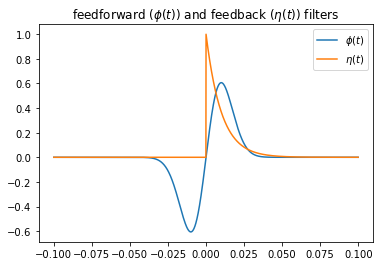

In [13]:
# plot filters
t_filter = np.arange(-0.1, 0.1, 1/10000)

filter_phi = phi(t_filter, 100, 100)
filter_eta = eta(t_filter, 100, 100)

plt.plot(t_filter, filter_phi, label = '$\phi(t)$')
plt.plot(t_filter, filter_eta, label = '$\eta(t)$')
plt.legend()
_ = plt.title('feedforward ($\phi(t)$) and feedback ($\eta(t)$) filters')

The feedforward filter is convolved with the stimulus. It implements an inverse derivative and therefore detects changes in the stimulus. It has a positive influence on the firing rate and therefore, with higher stimulus differences, higher firing rates are achieved.

The feedback filter is convolved with the spike train. It implements a refractory period because it has a negative influence on the firing rate with a spike that has occurred most recently having the largest influence.

(e) Load the stimulus s and the measured spike train y from y.npy and s.npy (sampling rate 10 kHz) and fit the model parameters by maximizing the likelihood (use scipy.optimize.fmin)

Stimulus vector with shape: (20000,)
[ 0.          0.          0.75077961  2.20773205  2.17012343  1.14759279
 -0.51637267 -0.37016691 -0.06189373  0.74356168  0.50177547  0.5783246
  0.8356952   0.29796826  0.89291464  0.57795062  0.01250628 -1.60580353
 -1.3512797  -0.0041299 ]

Spike vector with shape: (20000,)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Unique values in y: [0. 1.]


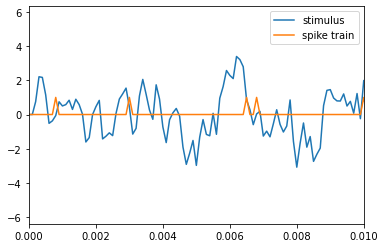

In [14]:
# load and investigate stimulus and spike train
s = np.load('s.npy')
y = np.load('y.npy')

print('Stimulus vector with shape:', s.shape)
print(s[:20])
print('\nSpike vector with shape:', y.shape)
print(y[:20])
print('Unique values in y:', np.unique(y))

sr = 10000
ts = 1/sr
t = np.arange(0, len(s)/sr, ts)

plt.plot(t, s, label = 'stimulus')
plt.plot(t, y, label = 'spike train')
plt.xlim(0, 0.01)
_ = plt.legend()

In [15]:
# functions for computing the negative log-likelihood and optimization
def negative_likelihood(theta, *args):
    # theta is passed as single array that is divided up into two arrays for the two filters
    rate = np.exp(np.convolve(s, theta[:len_filter], mode = 'same') - np.convolve(y, theta[len_filter:], mode = 'same')) * ts
    log_lik = np.sum((y * rate - rate))
    return -log_lik

def minimize_likelihood(s, y, ts, len_filter):
    guess_theta = np.zeros(len_filter*2)
    res = optimize.minimize(negative_likelihood, guess_theta, args=(s,y,ts,len_filter))
    return res['x']

Text(0.5, 1.0, 'feedback filter')

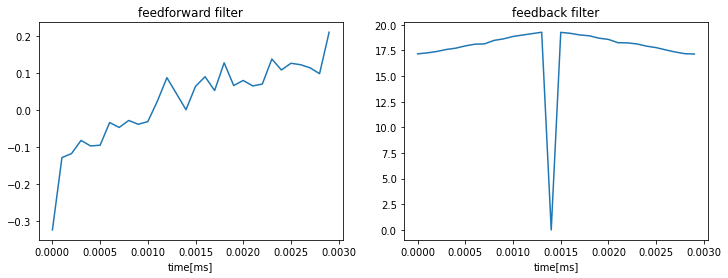

In [16]:
# define filter length and obtain otpimal filter parameters
len_filter = 30
theta = minimize_likelihood(s, y, ts, len_filter)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

t_filter_opt = np.arange(0, len_filter * ts, ts)
ax[0].plot(t_filter_opt, theta[:len_filter])
ax[0].set_xlabel('time[ms]')
ax[0].set_title('feedforward filter')

ax[1].plot(t_filter_opt, theta[len_filter:])
ax[1].set_xlabel('time[ms]')
ax[1].set_title('feedback filter')